In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

sns.set(font_scale=1.5)

%config InlineBackend.figure_format = 'retina'
%matplotlib inline

In [2]:
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.linear_model import ElasticNet
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA

In [3]:
df = pd.read_csv('../Pt3_Data_processing/poly_ewm18.csv')
df.sort_values(by='h_pg_date', inplace=True)

# Turning IDS into categorical variables
for col in df:
    if 'id' in col:
        df[col]=df[col].astype('category')
    
# Turning age into integers        
for col in [col for col in df if 'age' in col]:
    df[col] = df[col].apply(lambda x: int(x.replace(' days 00:00:00.000000000','')))
    
df.drop_duplicates(inplace=True)
df.drop(columns='Unnamed: 0', inplace=True)
df.columns

Index(['h_pg_date', 'h_pg_season_id', 'h_pg_location', 'h_pg_type',
       'h_pg_outcome', 'h_pg_difference', 'h_pg_game_id', 'h_pg_team_id',
       'h_pg_team_abb', 'h_pg_team_city',
       ...
       'a_s3_ewm_tm_tov_pct^2', 'a_s3_ewm_tm_tov_pct ewm_usg_pct',
       'a_s3_ewm_tm_tov_pct ewm_game_score',
       'a_s3_ewm_tm_tov_pct ewm_plus_minus', 'a_s3_ewm_usg_pct^2',
       'a_s3_ewm_usg_pct ewm_game_score', 'a_s3_ewm_usg_pct ewm_plus_minus',
       'a_s3_ewm_game_score^2', 'a_s3_ewm_game_score ewm_plus_minus',
       'a_s3_ewm_plus_minus^2'],
      dtype='object', length=9044)

In [17]:
name_id_remove = [col for col in df if any(c in col for c in ['_player_id','_name', '_team'])]

modelling_columns = ['h_pg_outcome', 'h_pg_difference', 'h_pg_type', 'h_pg_location'] + \
[col for col in df.loc[:,'h_pg_age_days':] if \
                     col not in name_id_remove]

X = df[modelling_columns].copy()
# X.fillna(value=0, inplace=True)

print('COVID\n',X['h_pg_outcome'][X['a_pg_date']>'2020-03-30'].value_counts(normalize=True))
print('\n2018-\n',X['h_pg_outcome'][X['a_pg_date']>'2018-08-30'].value_counts(normalize=True))
print('\n-2018\n',X['h_pg_outcome'][X['a_pg_date']<'2018-08-30'].value_counts(normalize=True))
print('\n2019-\n',X['h_pg_outcome'][X['a_pg_date']>'2019-08-30'].value_counts(normalize=True))
print('\n-2019\n',X['h_pg_outcome'][X['a_pg_date']<'2019-08-30'].value_counts(normalize=True))

X[X['a_pg_date']>'2017-08-30'].shape[0], X[X['a_pg_date']<'2017-08-30'].shape[0]

# # REMOVING FIRST YEAR OF GAMES AND POST-COVID 
# # (GAMES NOT PLAYED ON HOME COURTS, DATA CONSTRUCTION WOULD CAUSE ISSUES)
# X.drop(X[X['a_pg_date']<'2001-08-30'].index, inplace=True)
# X.drop(X[X['a_pg_date']>'2020-03-30'].index, inplace=True)

# print('\nBASELINE FOR TOTAL DATASET :\n',X['h_pg_outcome'].value_counts(normalize=True))

# print('\nDF SHAPE :\n',X.shape)

COVID
 1    0.533333
0    0.466667
Name: h_pg_outcome, dtype: float64

2018-
 1    0.571667
0    0.428333
Name: h_pg_outcome, dtype: float64

-2018
 1    0.600805
0    0.399195
Name: h_pg_outcome, dtype: float64

2019-
 1    0.549639
0    0.450361
Name: h_pg_outcome, dtype: float64

-2019
 1    0.600271
0    0.399729
Name: h_pg_outcome, dtype: float64


(3673, 21824)

In [9]:
from sklearn.model_selection import train_test_split

In [18]:
X.drop(columns=['a_pg_season_id', 'a_pg_location', 'a_pg_type',
       'a_pg_outcome', 'a_pg_difference', 'a_pg_game_id','a_pg_date','h_pg_outcome'], inplace=True)

X.fillna(0, inplace=True)
y = X.pop('h_pg_difference')


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [5]:
# X.drop(columns=['a_pg_season_id', 'a_pg_location', 'a_pg_type',
#        'a_pg_outcome', 'a_pg_difference', 'a_pg_game_id'], inplace=True)

# X.fillna(0, inplace=True)


# X_train = X[X['a_pg_date']<'2017-08-30'].copy()
# X_test = X[X['a_pg_date']>'2017-08-30'].copy()

# X_train.drop(columns='a_pg_date', inplace=True)
# X_test.drop(columns='a_pg_date', inplace=True)


# yC_train = X_train.pop('h_pg_outcome')
# yC_test = X_test.pop('h_pg_outcome')

# yR_train = X_train.pop('h_pg_difference')
# yR_test = X_test.pop('h_pg_difference')

In [19]:
pipe = Pipeline([('scaler', StandardScaler()),
                ('pca', PCA(n_components=500)),
                ('model', ElasticNet(max_iter=1000000))])
pipe

Pipeline(steps=[('scaler', StandardScaler()), ('pca', PCA(n_components=500)),
                ('model', ElasticNet(max_iter=1000000))])

In [20]:
# model = ElasticNet(max_iter=1000000)

kf = KFold(shuffle=True)

gs_params = {'model__alpha' : np.linspace(.0001,10,11),
            'model__l1_ratio': np.linspace(0.0001,1,11)}

grid = GridSearchCV(pipe, gs_params, n_jobs=2, cv=kf, verbose=3, scoring='neg_root_mean_squared_error')

grid.fit(X_train, y_train)

Fitting 5 folds for each of 121 candidates, totalling 605 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  28 tasks      | elapsed: 15.5min
[Parallel(n_jobs=2)]: Done 124 tasks      | elapsed: 54.0min
[Parallel(n_jobs=2)]: Done 284 tasks      | elapsed: 118.3min
[Parallel(n_jobs=2)]: Done 508 tasks      | elapsed: 212.2min
[Parallel(n_jobs=2)]: Done 605 out of 605 | elapsed: 249.8min finished


GridSearchCV(cv=KFold(n_splits=5, random_state=None, shuffle=True),
             estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                       ('pca', PCA(n_components=500)),
                                       ('model',
                                        ElasticNet(max_iter=1000000))]),
             n_jobs=2,
             param_grid={'model__alpha': array([1.00000e-04, 1.00009e+00, 2.00008e+00, 3.00007e+00, 4.00006e+00,
       5.00005e+00, 6.00004e+00, 7.00003e+00, 8.00002e+00, 9.00001e+00,
       1.00000e+01]),
                         'model__l1_ratio': array([1.0000e-04, 1.0009e-01, 2.0008e-01, 3.0007e-01, 4.0006e-01,
       5.0005e-01, 6.0004e-01, 7.0003e-01, 8.0002e-01, 9.0001e-01,
       1.0000e+00])},
             scoring='neg_root_mean_squared_error', verbose=3)

In [21]:
grid.best_score_

-12.133107173594192

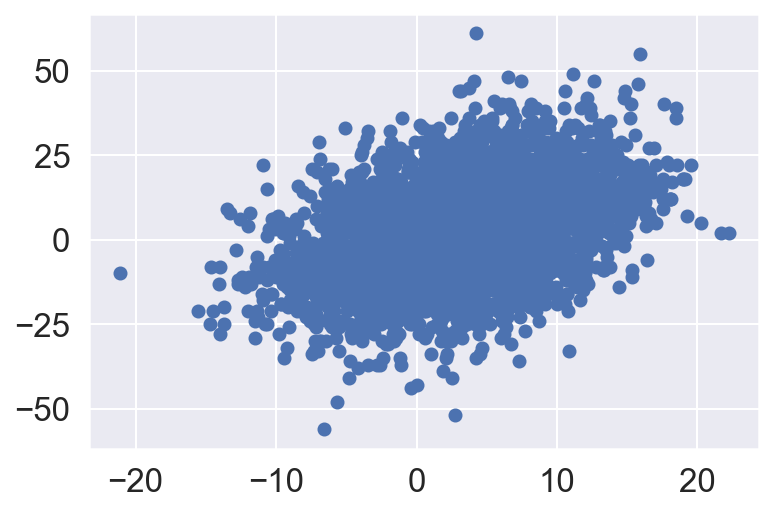

In [22]:
plt.scatter(grid.predict(X_test), y_test)

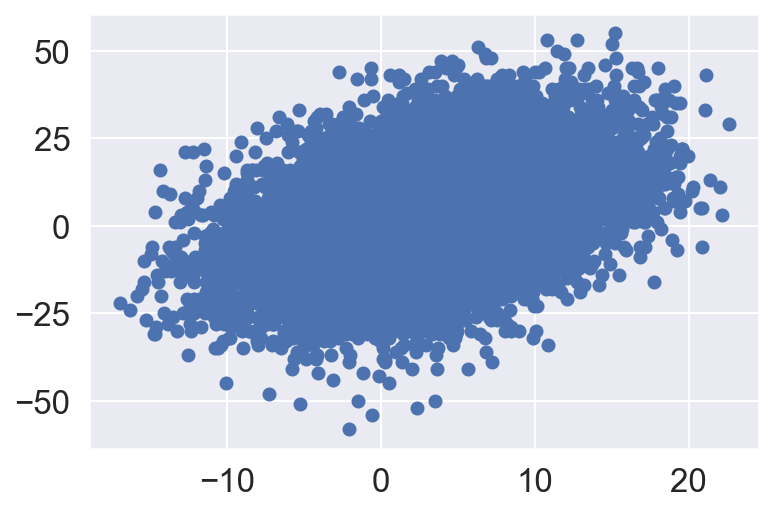

In [11]:
plt.scatter(grid.predict(X_train), yR_train)

In [12]:
grid.best_estimator_

Pipeline(steps=[('scaler', StandardScaler()), ('pca', PCA(n_components=500)),
                ('model',
                 ElasticNet(alpha=3.0000700000000005, l1_ratio=0.0001,
                            max_iter=1000000))])

In [13]:
grid.best_params_

{'model__alpha': 3.0000700000000005, 'model__l1_ratio': 0.0001}

In [24]:
grid.predict(X_test)

array([ 11.28716519,  -4.54275861,  -9.12192079, ..., -11.3624379 ,
        15.93837787,  10.21672726])

In [26]:
np.array(yR_test)

array([  3,  -1,  -5, ..., -11,  18,  16])

In [14]:
grid.best_estimator_.named_steps['model'].coef_

array([ 3.04070305e-02, -2.85330995e-01,  8.61586227e-02, -1.22042812e-01,
       -4.45421604e-02,  3.71231896e-02,  5.15045745e-02,  8.44387718e-03,
       -3.06270700e-02,  1.17302615e-02, -1.29993634e-03,  1.44083235e-05,
        2.03977812e-02,  3.41468029e-02, -2.53999849e-02, -1.01509359e-03,
        5.26232014e-03, -8.43722499e-03, -2.44876315e-02, -2.67070377e-03,
        2.43741846e-03,  5.71900729e-03, -4.76760471e-03, -1.34480651e-02,
        1.52899999e-03, -4.69825468e-03, -1.49715277e-02, -1.38035573e-02,
        1.29775978e-02, -1.30285636e-03, -4.80117238e-03,  2.88167871e-03,
        1.93278741e-02, -4.76959857e-04, -1.27970575e-03,  1.54994159e-02,
        1.67866702e-02,  1.33031413e-03,  1.10600855e-02, -1.19321901e-03,
       -1.36897156e-02, -7.95286216e-03,  1.83028519e-02,  5.25458334e-03,
       -1.19922585e-02, -7.86405945e-04, -9.98110810e-03, -1.23135937e-02,
       -1.69314918e-02,  2.10463062e-02, -1.08893222e-02,  5.59289752e-03,
        2.41701781e-03, -

In [16]:
[col for col in X_train.columns if 'date' in col]

['a_pg_date']